In [1]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

In [3]:
def get_vector_dist(a, b):
    x_ = abs(a[0] - b[0])
    y_ = abs(a[1] - b[1])
    return x_ + y_
    
class Heatmap(object):
    def __init__(self, shape, kernel_size=35, heat_strength=5):
        self.kernel_size = kernel_size
        self.heat_strength = heat_strength
        self.kernel_gen()
        self.cx_k = self.kernel_size // 2
        self.cy_k = self.kernel_size // 2
        m = (self.kernel_size - 1) // 2
        self.k_range = range(-m, m + 1)
        self.mask = np.zeros(shape, dtype=np.uint8)
    
    def kernel_gen(self):
        assert self.kernel_size % 2 == 1, "Kernel size support only odd number."
        self.kernel = np.zeros((self.kernel_size, self.kernel_size), dtype=np.uint8)
        c = self.kernel_size // 2
        for y in range(self.kernel_size):
            vector = []
            for x in range(self.kernel_size):
                dist = get_vector_dist((x, y), (c, c))
                vector.append(max(0, self.kernel_size - (dist * 2)))
            self.kernel[y] = np.array(vector)
    
    def get_center(self, bboxes):
        points = []
        for bbox in bboxes:
            x, y, x2, y2 = bbox[:4].astype(np.int8)
            cx = (x2 + x) // 2
            cy = (y2 + y) // 2
            points.append((cx, cy))
        return points
    
    def apply(self, bboxes, centered=False):
        for cx, cy in bboxes if centered else self.get_center(bboxes):
            for y_k in self.k_range:
                for x_k in self.k_range:
                    cx_, cy_ = cx + x_k, cy + y_k
                    if cx_ > self.mask.shape[0] - 1 or cy_ > self.mask.shape[1] - 1:
                        continue
                    new_value = self.mask[cx_, cy_, 0] + self.kernel[self.cx_k + x_k, self.cy_k + y_k] * self.heat_strength
                    if new_value < 255:
                        self.mask[cx_, cy_] += self.kernel[self.cx_k + x_k, self.cy_k + y_k] * self.heat_strength
                    else:
                        self.mask[cx_, cy_] = np.array([255, 255, 255])
    
    def get_heatmap(self):
        gray_mask = cv2.cvtColor(self.mask, cv2.COLOR_BGR2GRAY)
        return cv2.applyColorMap(gray_mask, cv2.COLORMAP_JET)

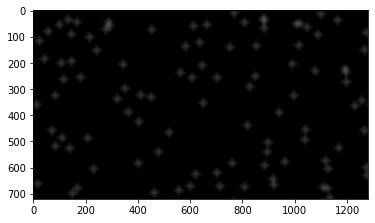

In [4]:
points = []
for i in range(100):
    points.append((np.random.randint(0, 720 - 1), np.random.randint(0, 1280 - 1)))

heatmap = Heatmap((720, 1280, 3), kernel_size=55, heat_strength=1)
heatmap.apply(points, centered=True)
plot(heatmap.mask)

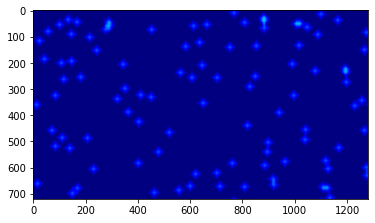

In [8]:
heatmap_img = heatmap.get_heatmap()
plot(heatmap_img)